In [1]:
import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()
import random
from pyspark import SparkContext
import pyspark
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
sc = SparkContext("local[*]", "Name of the Program")

In [2]:

def readFile(filename):
    rdd = sc.textFile(filename)
    rdd_numpy = rdd.map(lambda x : np.array(x.split(","), dtype = float))
    rdd_return = rdd_numpy.map(lambda x : (x[:-1], int(x[-1])))
    return rdd_return

def normalize_value(x, mean, std):
    value = (x[0] - mean) / std
    normalized_val = np.nan_to_num(value, copy=False, nan=0.0)
    return (normalized_val, x[1])

def normalize(RDD_Xy):
    
    rdd_sum = RDD_Xy.reduce(lambda x, y: (np.array(x[0]) + np.array(y[0]), x[1]))
    total_rows = float(RDD_Xy.count())
    mean = rdd_sum[0] / total_rows

    rdd_mean = RDD_Xy.map(lambda x: (x[0], x[1], mean)) 

    rdd_substract = rdd_mean.map(lambda x: (x[0] - x[2]) ** 2)
    rdd_total = rdd_substract.reduce(lambda x, y: x + y)
    std = (rdd_total / total_rows) ** 0.5
 

    rdd_normalized = RDD_Xy.map(lambda x: normalize_value(x, mean, std))
    return rdd_normalized

def predict(w, b, X, threshold=0.5):
    value = np.dot(w, X) + b
    value = 1 / (1 + np.exp(-value))
    return  1 if value > threshold else 0

def loss_function(x):
    return (-x[1] * np.log(x[0]) - (1 - x[1]) * np.log(1 - x[0]))

def calculate_loss_function(predictions_and_targets,lambda_reg,w):   
    """
    Calculate the loss function for logistic regression
    :param predictions_and_targets: RDD with the predictions and the targets
    :param lambda_reg: regularization parameter
    :param w: weights
    :return: loss function
    """

    loss = predictions_and_targets.map(loss_function)
    sum = loss.reduce(lambda x,y: x + y) / predictions_and_targets.count()
    squared_w = np.dot(w, w)
    squared_w = squared_w * lambda_reg / (2 * len(w))
    return sum + squared_w

def predict_train(w, b, X,):
    value = np.dot(w, X) + b
    return 1 / (1 + np.exp(-value))

def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

def accuracy(w,b,RDD_Xy):
    predictions_and_targets = RDD_Xy.map(lambda x: (predict(w, b, x[0]), x[1]))
    correct = predictions_and_targets.map(lambda x: 1 if round(x[0]) == x[1] else 0)
    correct = correct.reduce(lambda x, y: x + y)
    return correct / predictions_and_targets.count()

def transform(data,num_blocks_cv):
    data = data.map(lambda x: (random.randint(0, num_blocks_cv-1), x[0], x[1]))
    return data

def get_block_data(data_cv: pyspark.rdd.RDD, i):
    train_data = data_cv.flatMap(lambda x: [(x[1], x[2])] if x[0] != i else [])
    test_data = data_cv.flatMap(lambda x: [(x[1], x[2])] if x[0] == i else [])
    return train_data, test_data


## **EJERCICIO 1**

In [3]:
n = readFile('data/botnet_reduced_10k_l.csv')

normalizado = normalize(n)

w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")

Iteration: 0, Loss: [0.89542699]
Iteration: 1, Loss: [0.52021818]
Iteration: 2, Loss: [0.38342503]
Iteration: 3, Loss: [0.3211133]
Iteration: 4, Loss: [0.2867443]
Iteration: 5, Loss: [0.26502816]
Iteration: 6, Loss: [0.25001357]
Iteration: 7, Loss: [0.23897077]
Iteration: 8, Loss: [0.23047865]
Iteration: 9, Loss: [0.22372509]
Final accuracy: 0.9265


## **EJERCICIO 2**

In [4]:
num_blocks_cv=10
rdd_with_keys = transform(normalizado, num_blocks_cv)
rdd_with_keys.cache()
_ = rdd_with_keys.count() # to cache the data
all_ac=[]
for i in range(num_blocks_cv):
    train_data, test_data = get_block_data(rdd_with_keys, i)
    print("-"*50)
    print(f"Block {i}")
    w,b=train(train_data,10,1.5,0)
    acc=accuracy(w,b,test_data)
    all_ac.append(acc)
    print(f"Accuracy: {acc}")
print(f"Mean accuracy: {np.mean(all_ac)}")

--------------------------------------------------
Block 0
Iteration: 0, Loss: [0.67951989]
Iteration: 1, Loss: [0.45236981]
Iteration: 2, Loss: [0.35023065]
Iteration: 3, Loss: [0.29937167]
Iteration: 4, Loss: [0.27077357]
Iteration: 5, Loss: [0.25265157]
Iteration: 6, Loss: [0.24009426]
Iteration: 7, Loss: [0.23082054]
Iteration: 8, Loss: [0.22364764]
Iteration: 9, Loss: [0.21790467]
Accuracy: 0.9262213359920239
--------------------------------------------------
Block 1
Iteration: 0, Loss: [0.74380911]
Iteration: 1, Loss: [0.45236885]
Iteration: 2, Loss: [0.34523535]
Iteration: 3, Loss: [0.29529057]
Iteration: 4, Loss: [0.26763001]
Iteration: 5, Loss: [0.25021881]
Iteration: 6, Loss: [0.23821893]
Iteration: 7, Loss: [0.22939731]
Iteration: 8, Loss: [0.22259948]
Iteration: 9, Loss: [0.21717289]
Accuracy: 0.9400196656833825
--------------------------------------------------
Block 2
Iteration: 0, Loss: [0.71340945]
Iteration: 1, Loss: [0.4731573]
Iteration: 2, Loss: [0.36397715]
Iterati

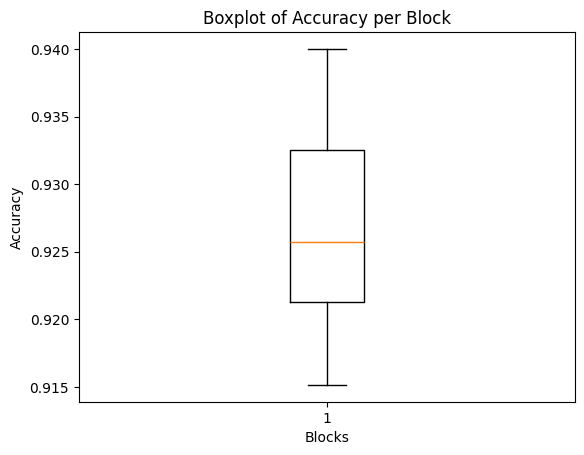

In [7]:
import matplotlib.pyplot as plt
plt.boxplot(all_ac)
plt.xlabel('Blocks')
plt.ylabel('Accuracy')
plt.title('Boxplot of Accuracy per Block')
plt.show()

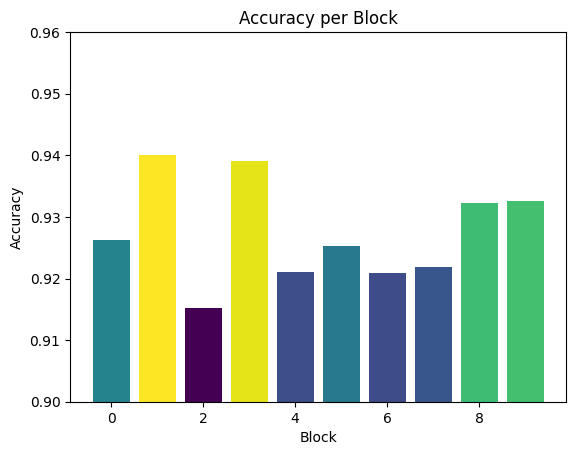

In [13]:
colors = plt.cm.viridis((np.array(all_ac) - min(all_ac)) / (max(all_ac) - min(all_ac)))
plt.bar(range(num_blocks_cv), all_ac, color=colors)
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy per Block')
plt.ylim(0.90, 0.96)
plt.show()


# Memoria parte 1

In [4]:
def ej1_train(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    costs = []
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        costs.append(loss)
    return w, b, costs

Learning rates::   0%|          | 0/7 [00:00<?, ?it/s]Exception in thread "serve RDD 656" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
Learning rates:: 100%|██████████| 7/7 [01:43<00:00, 14.76s/it]


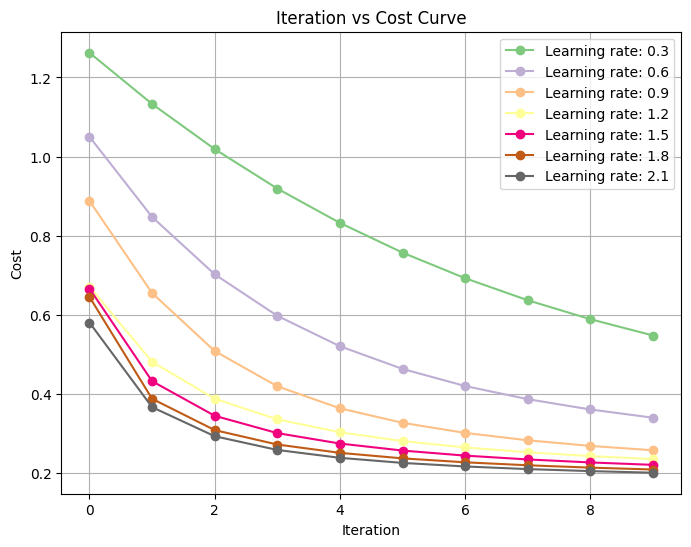

In [13]:
n = readFile('data/botnet_reduced_10k_l.csv')

normalizado = normalize(n)
total_costs=[]
learning_rates=[0.3,0.6,0.9,1.2,1.5,1.8,2.1]

colors = plt.cm.Accent((np.array(learning_rates) - min(learning_rates)) / (max(learning_rates) - min(learning_rates)))
lambda_reg=0
plt.figure(figsize=(8, 6))
for learning_rate in tqdm(learning_rates, desc=f"Learning rates"):
    w,b,costs=ej1_train(normalizado,10,learning_rate,0)
    total_costs.append(costs)

    plt.plot(costs, marker='o', linestyle='-',color=colors[learning_rates.index(learning_rate)],label=f"Learning rate: {learning_rate}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration vs Cost Curve")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_1_cost_curve_learning_rate.png")  # Guardar imagen
plt.show()

Lambdas:   0%|          | 0/7 [00:00<?, ?it/s]Exception in thread "serve RDD 1185" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
Lambdas: 100%|██████████| 7/7 [01:42<00:00, 14.62s/it]


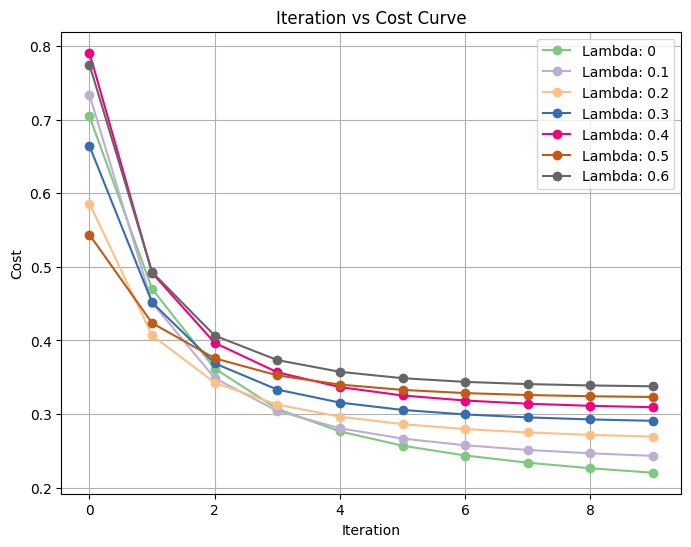

In [15]:
n = readFile('data/botnet_reduced_10k_l.csv')

normalizado = normalize(n)
lambdas=[0,0.1,0.2,0.3,0.4,0.5,0.6]

colors = plt.cm.Accent((np.array(lambdas) - min(lambdas)) / (max(lambdas) - min(lambdas)))
plt.figure(figsize=(8, 6))
for lamb in tqdm(lambdas, desc=f"Lambdas"):
    w,b,costs=ej1_train(normalizado,10,1.5,lamb)

    plt.plot(costs, marker='o', linestyle='-',color=colors[lambdas.index(lamb)],label=f"Lambda: {lamb}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration vs Cost Curve")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_1_cost_curve_lambda.png")  # Guardar imagen
plt.show()

## Memoria Parte 2

Workers:   0%|          | 0/15 [00:00<?, ?it/s]Exception in thread "serve RDD 5" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
Workers: 100%|██████████| 15/15 [03:59<00:00, 15.96s/it]                        


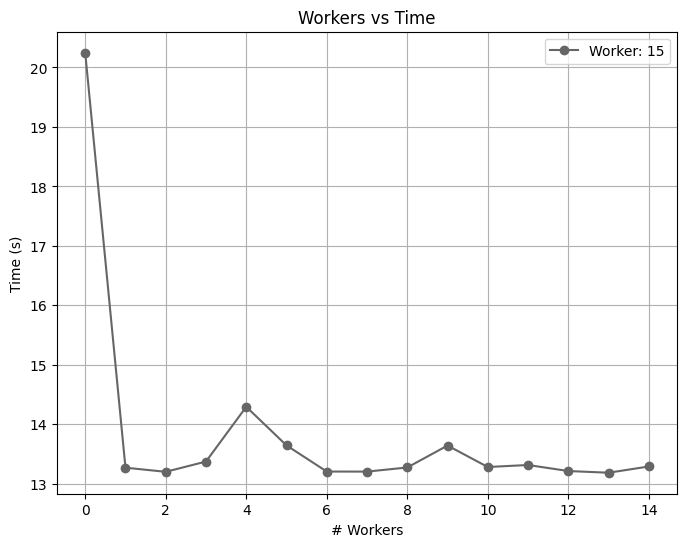

In [9]:

n_worker=12
workers=range(1,n_worker+4)

try:
    sc.stop()
except:
    pass
totals=[]
plt.figure(figsize=(8, 6))
for worker in tqdm(workers, desc=f"Workers"):
    sc = SparkContext(f"local[{worker}]", "Name of the Program")
    n = readFile('data/botnet_reduced_10k_l.csv')   
    normalizado = normalize(n)
    inicio=time.time()
    w,b,costs=ej1_train(normalizado,10,1.5,0)
    fin=time.time()
    sc.stop()
    totals.append(fin-inicio)

plt.plot(range(1, len(totals) + 1), totals, marker='o', linestyle='-')
plt.xlabel("# Workers")
plt.ylabel("Time (s)")
plt.title("Workers vs Time")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_2_time_workers.png") 
plt.show()

## Memoria Parte 4

Partitions: 100%|██████████| 2/2 [00:21<00:00, 10.50s/it]                       


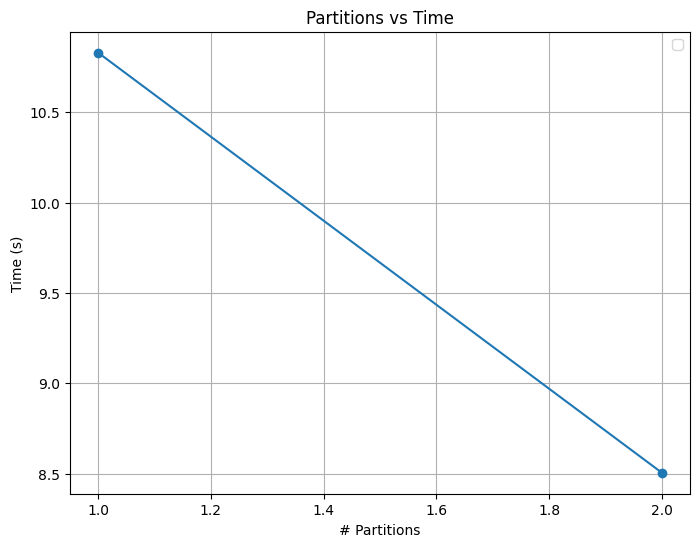

In [8]:
partitions=range(1,9)


try:
    sc.stop()
except:
    pass
sc = SparkContext(f"local[{4}]", "Name of the Program")
totals=[]
plt.figure(figsize=(8, 6))
for partition in tqdm(partitions, desc=f"Partitions"):
    
    n = readFile('data/botnet_reduced_10k_l.csv')   
    normalizado = normalize(n)
    normalizado=normalizado.repartition(partition)

    inicio=time.time()
    w,b,costs=ej1_train(normalizado,10,1.5,0)
    fin=time.time()
    totals.append(fin-inicio)

plt.plot(range(1, len(totals) + 1), totals, marker='o', linestyle='-')
plt.xlabel("# Partitions")
plt.ylabel("Time (s)")
plt.title("Partitions vs Time")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_4_time_partitions.png") 
plt.show()